## (18+) Нахождение топ-10 слов в её песнях с помощью инструментов обработки естественного языка. 
### провел исследование: Киселев Илья

Воспользуемся парой библиотек.

In [1]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
import nltk
from nltk.corpus import stopwords
import squarify
from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    PER,
    LOC,
    NamesExtractor,
    DatesExtractor,
    MoneyExtractor,
    AddrExtractor,
    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)
dates_extractor = DatesExtractor(morph_vocab)
money_extractor = MoneyExtractor(morph_vocab)
addr_extractor = AddrExtractor(morph_vocab)

Откроем файл, где содержатся все тексты песен Инстасамки.

In [2]:
file = open('analys_instasamka.txt')
text = file.read()
text[:1000]

'Сто из ста, Samka сто из ста\nНа моём аккаунте up, передай мне cup\nСто из ста, Samka сто из ста\nУ меня sold out, парень снова опоздал\nСто из ста, Samka сто из ста\nЯ одна на миллион, да, я граблю банк\nСто из ста, да, я сто из ста\nНа моём аккаунте up, передай мне cup\nСто из ста, снова 100 из ста\nЭй, lil bitch, не лезь сюда, занимай места\n\n\nIce, ice, baby\nМне будет похуй на тебя, когда будешь на небе\nПарень, отъебись, сейчас не время\nНе пиши мне в директ, даже не отвечу\nЭто всё пиздёж, время нас не лечит\nАлкоголь залечит мои раны\nЯ не вижу конкурентов, это правда\nGucci, Louis, Prada в деле (много денег)\nХолод, ice на моём теле\nСто из ста, сука, кто здесь сто из ста\nГраблю, нахуй, города, Samka в туре, я звезда\nCadillac едет на тихом и уже не Silent Hill\nЗаберу своё по праву, нет хуя, но трахну мир\nИ мне по(уй на твой хейт, на мне сияет ice drip\nЗаписала два альбома — это б(ядский double kill\nDouble pill в одном бокале, да, я скинула бока\nЕсли вам нужна инфа — п

### Описание функций из библиотеки Natasha для анализа текста и определение задачи.

Задача - разбить слова на токены, а также найти синонимы. \
Использумые функции: \
1. segmenter: разделяет текст на токены и предложения, определяет свойства токенов. \
2. morph_tagger: для каждого токена извлеките теги с богатой морфологией. \
3. syntax_parser: для каждого предложения запускайте синтаксический анализатор. 

In [3]:
doc = Doc(text)
doc.segment(segmenter) 
doc.tag_morph(morph_tagger)
doc.parse_syntax(syntax_parser)

In [4]:
display(doc.tokens[:5])

[DocToken(stop=3, text='Сто', id='1_1', head_id='1_568', rel='nsubj', pos='NUM', feats=<Nom>),
 DocToken(start=4, stop=6, text='из', id='1_2', head_id='1_437', rel='case', pos='ADP'),
 DocToken(start=7, stop=10, text='ста', id='1_3', head_id='1_262', rel='nmod', pos='NUM', feats=<Gen>),
 DocToken(start=10, stop=11, text=',', id='1_4', head_id='1_254', rel='punct', pos='PUNCT'),
 DocToken(start=12, stop=17, text='Samka', id='1_5', head_id='1_663', rel='nsubj', pos='PROPN', feats=<Yes>)]

In [5]:
for token in doc.tokens:
    token.lemmatize(morph_vocab)

Теперь запишем все синонимы токенов в отдельную переменную, и уже над ней будем проводить очситку и анализ.

In [6]:
lemmas = [_.lemma for _ in doc.tokens]

Предварительная очистка слов от знаков препинания и некоторых стоп-слов.

In [7]:
i=0
lemmas_precorrected = []
while i < len(lemmas):
    if (lemmas[i] != ',') and (lemmas[i] != '—') and (lemmas[i] != ')') and (lemmas[i] != '(') \
    and (lemmas[i] != 'я') and  (lemmas[i] != 'на') and  (lemmas[i] != 'на') and  (lemmas[i] != '!') \
    and  (lemmas[i] != 'на')  and  (lemmas[i] != 'весь')  and  (lemmas[i] != 'это')  and  (lemmas[i] != 'твой') \
    and  (lemmas[i] != '?') and  (lemmas[i] != '’') and  (lemmas[i] != 'свой') and  (lemmas[i] != 'эй') \
    and  (lemmas[i] != ':') and  (lemmas[i] != '«') and (lemmas[i] != '»') and (lemmas[i] != '.') and (lemmas[i] != '?!'):
        lemmas_precorrected.append(lemmas[i])
        i += 1
    else:
        i += 1

Очистка данных от стоп-слов из пакета ntlk.

In [8]:
russian_stopwords = set(stopwords.words("russian"))
def remove_stopwords(tokens):
    cleaned_tokens = []
    for token in tokens:
        if token not in russian_stopwords:
            cleaned_tokens.append(token)
    return cleaned_tokens
lemmas_corrected = remove_stopwords(lemmas_precorrected)

Теперь, когда у нас есть токены, мы можем приступить к самому простому анализу. \
Подсчитаем количество слов через Counter. \
Выведем топ-10 популярных слов. 

In [15]:
def word_counter(tokens):
    word_counts = Counter()
    word_counts.update(tokens)
    return word_counts 

word_count = word_counter(lemmas_corrected)
word_count_30 = word_count.most_common(30)
word_count.most_common(10)

[('bitch', 209),
 ('money', 201),
 ('сука', 184),
 ('деньга', 156),
 ('mommy', 108),
 ('мама', 101),
 ('доллар', 101),
 ('купить', 99),
 ('знать', 87),
 ('делать', 79)]

На гистограме отобразим частоту появления слов в треках инстасамки.

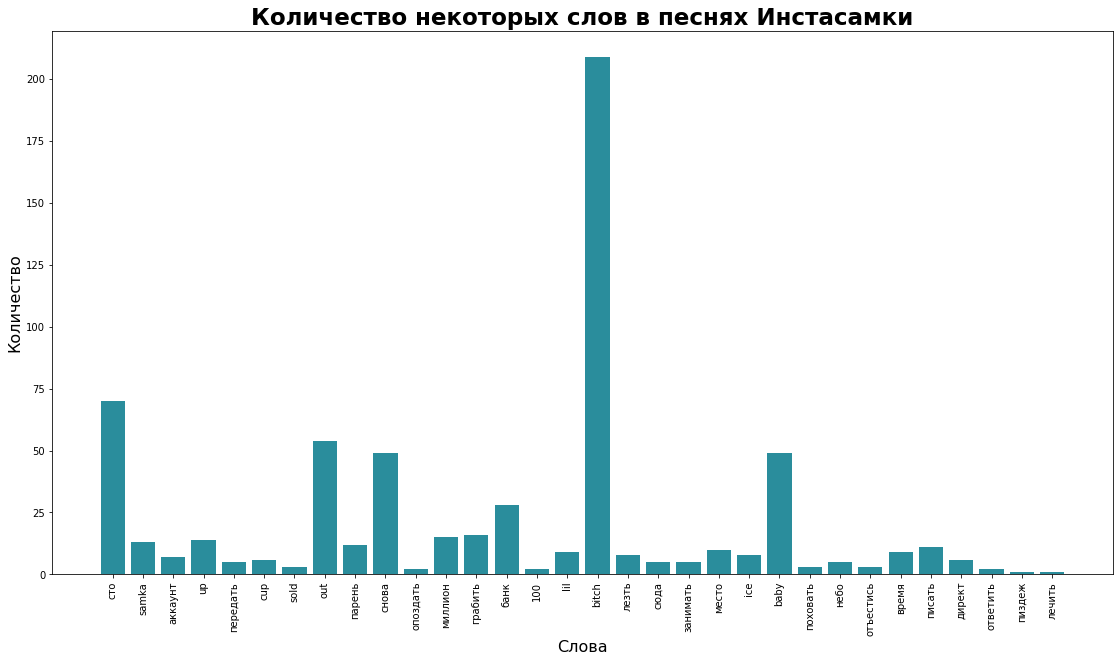

In [10]:
fig = plt.figure(figsize=(19, 10))

myhex = '#2A8D9C'
x = list(word_count.keys())[:32]
y = list(word_count.values())[:32]

plt.bar(x, y, color = myhex)

plt.xlabel('Слова', fontsize=16)
plt.xticks(rotation=90)
plt.ylabel('Количество', fontsize=16)

plt.title("Количество некоторых слов в песнях Инстасамки",fontsize=23,fontweight="bold")
plt.show();

Визуализируем данные, упорядочив по убыванию.

In [11]:
word, count_word = zip(*word_count_30)

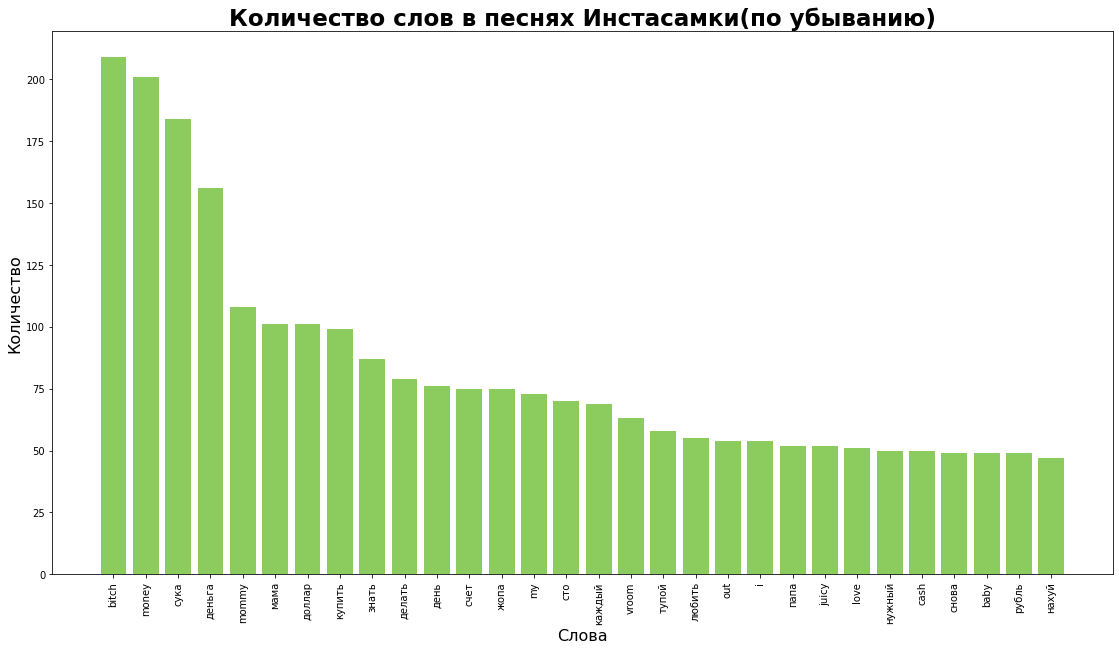

In [12]:
fig = plt.figure(figsize=(19, 10))

myhex = '#8CCB5E'
x = list(word)[:32]
y = list(count_word)[:32]

plt.bar(x, y, color = myhex)

plt.xlabel('Слова', fontsize=16)
plt.xticks(rotation=90)
plt.ylabel('Количество', fontsize=16)

plt.title("Количество слов в песнях Инстасамки(по убыванию)",fontsize=23,fontweight="bold")
plt.show();

Количество слов может быть полезно, но обычно требуется более глубокий анализ, 
отвечающий на наши вопросы, особенно когда данные состоят не из одного документа. 

Мы можем создать таблицу, создав Pandas DataFrame, содержащий функции, возвращающие: 
1. Количество токенов.
2. Их ранг по частотности употребления по отношению к другим токенам. 
3. Процент токенов от общего состава документа. 

In [13]:
temp = list(zip(word_count.keys(), word_count.values()))
wc = pd.DataFrame(temp, columns = ['word', 'count'])
wc['rank'] = wc['count'].rank(method='first', ascending=False)
total = wc['count'].sum()
wc['pct_total'] = wc['count'].apply(lambda x: x / total)
wc_10 = wc.sort_values('count', ascending=False).iloc[:10]

Как видно из стобцов count and rank самым популярным словом является 'bitch'.

Построим Cureemap, где уже наглядно будут видны популярные слова.

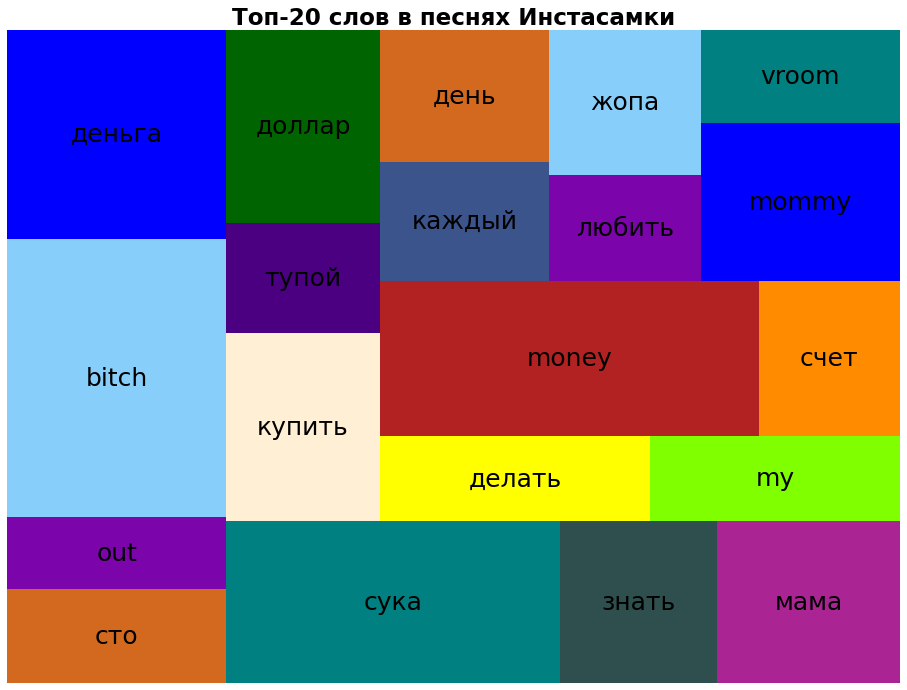

In [16]:
some_colors = ['#D2691E', '#7b04ab', '#87CEFA','#0000FF','#008080'\
              ,'#2F4F4F','#ab2493','#FFEFD5','#4B0082','#006400' \
              ,'#FFFF00','#7FFF00','#B22222','#FF8C00', '#3c548c']

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 12)

wc_top20 = wc[wc['rank'] <= 20]
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], \
        color=some_colors, \
        alpha=1, \
        text_kwargs={'fontsize':25})
plt.title("Топ-20 слов в песнях Инстасамки",fontsize=23,fontweight="bold")
plt.axis('off')
plt.show();

С помощью визуализации получилось представить, какие слова популярны.